In [2]:
%pip install deap

  Using cached deap-1.4.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached deap-1.4.2-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (135 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


gen	evals	std	min                    	avg	max                    
0  	100  	   	[0.00286063 2.57861903]	   	[0.97476915 6.44272424]
1  	100  	   	[6.02423400e-04 2.57861903e+00]	   	[0.97476915 6.48331612]
2  	100  	   	[5.30073031e-04 2.47659970e+00]	   	[0.99267103 6.53957113]
3  	100  	   	[2.97913440e-04 2.22675648e+00]	   	[0.99267103 6.48331612]
4  	100  	   	[2.07305106e-04 2.07374139e+00]	   	[0.96957302 5.93281549]
5  	100  	   	[2.07305106e-04 2.02523283e+00]	   	[0.96706594 5.93281549]
6  	100  	   	[2.07305106e-04 1.77314165e+00]	   	[0.97310193 5.57671252]
7  	100  	   	[1.38421482e-04 1.61611780e+00]	   	[0.96606351 5.22272037]
8  	100  	   	[4.39661668e-07 1.59261299e+00]	   	[0.84229315 5.22272037]
9  	100  	   	[4.39661668e-07 1.54741960e+00]	   	[0.84474203 4.81352771]
10 	100  	   	[4.39661668e-07 1.43678549e+00]	   	[0.84864401 4.43421691]
11 	100  	   	[3.53874935e-07 1.33582004e+00]	   	[0.84864401 4.72092885]
12 	100  	   	[3.53874935e-07 1.25339886e+00]	   	[0.8

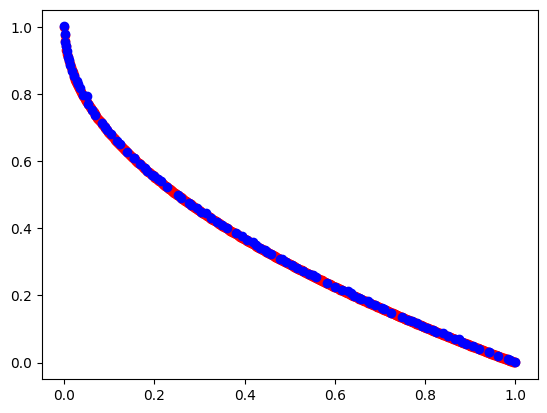

In [2]:
import array
import random
import json
import numpy
import matplotlib.pyplot as plt

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", benchmarks.zdt1)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

def main(toolbox,seed=None):
    random.seed(seed)

    NGEN = 250
    MU = 100
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    pop = toolbox.population(n=MU)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]

        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)

            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            del ind1.fitness.values, ind2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook

def check_results(toolbox,function):
    with open(f"pareto_front/{function}_front.json") as optimal_front_data:
        optimal_front = json.load(optimal_front_data)
    #Use 500 of the 1000 points in the json file
    optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))

    pop, stats = main(toolbox)
    pop.sort(key=lambda x: x.fitness.values)

    print(stats)
    print("Convergence: ", convergence(pop, optimal_front))
    print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))

    front = numpy.array([ind.fitness.values for ind in pop])
    optimal_front = numpy.array(optimal_front)
    plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
    plt.scatter(front[:,0], front[:,1], c="b")
    plt.axis("tight")
    plt.show()

check_results(toolbox,'zdt1')

gen	evals	std	min                            	avg	max                    
0  	100  	   	[2.26211223e-03 4.11499946e+00]	   	[0.99983404 6.52645249]
1  	100  	   	[2.26211223e-03 4.04102926e+00]	   	[0.99993512 5.99363847]
2  	100  	   	[2.12905399e-04 3.93177164e+00]	   	[0.99993512 6.11200914]
3  	100  	   	[2.12905399e-04 3.62441501e+00]	   	[0.99993512 5.36547465]
4  	100  	   	[2.12905399e-04 3.59295956e+00]	   	[0.99993512 5.31460095]
5  	100  	   	[1.93170333e-04 3.58735106e+00]	   	[0.99993512 5.31460095]
6  	100  	   	[1.93170333e-04 3.44990267e+00]	   	[0.9912088 5.583772 ]  
7  	100  	   	[7.15480966e-06 2.98658120e+00]	   	[0.99118935 5.2456192 ]
8  	100  	   	[5.95043376e-06 2.91533909e+00]	   	[0.99451857 4.73961444]
9  	100  	   	[5.95043376e-06 2.74679663e+00]	   	[0.99451857 4.65087758]
10 	100  	   	[4.20330167e-06 2.54790706e+00]	   	[0.99974127 4.85586636]
11 	100  	   	[2.05901811e-06 2.41503544e+00]	   	[0.99974127 4.49322355]
12 	100  	   	[2.05747443e-06 2.136768

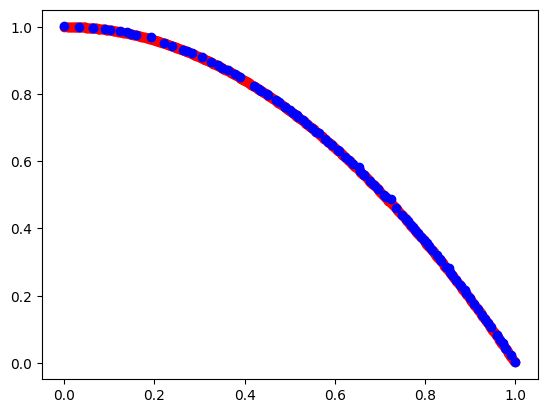

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox1 = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox1.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox1.register("individual", tools.initIterate, creator.Individual, toolbox1.attr_float)
toolbox1.register("population", tools.initRepeat, list, toolbox1.individual)

toolbox1.register("evaluate", benchmarks.zdt2)
toolbox1.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox1.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox1.register("select", tools.selNSGA2)

#pop, stats = main(toolbox1)
check_results(toolbox1,'zdt2')

/home/mm/projects/ewolucyjne/ewolucyjne/.venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mm/projects/ewolucyjne/ewolucyjne/.venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	std	min                    	avg	max                    
0  	100  	   	[0.02035464 2.37744891]	   	[0.99842449 5.69809751]
1  	100  	   	[0.02035017 2.37427356]	   	[0.99148384 5.76393326]
2  	100  	   	[0.00424645 2.35272135]	   	[0.82672248 5.78223209]
3  	100  	   	[0.00223165 2.0188425 ]	   	[0.82672248 5.78223209]
4  	100  	   	[2.67850819e-05 1.70552209e+00]	   	[0.86327753 5.43492942]
5  	100  	   	[2.67850819e-05 1.32407847e+00]	   	[0.86327753 5.15904507]
6  	100  	   	[5.29111198e-06 1.32407847e+00]	   	[0.86327753 5.15904507]
7  	100  	   	[4.95349762e-06 1.14435740e+00]	   	[0.84779437 5.34230096]
8  	100  	   	[4.95349762e-06 1.04479935e+00]	   	[0.85069465 5.34230096]
9  	100  	   	[8.19497152e-07 8.71417251e-01]	   	[0.85069465 4.97448398]
10 	100  	   	[8.19497152e-07 7.92855286e-01]	   	[0.85258865 4.81691645]
11 	100  	   	[8.19497152e-07 7.92855286e-01]	   	[0.85238568 4.78880998]
12 	100  	   	[8.19497152e-07 7.89707875e-01]	   	[0.85238568 4.49019562]
13 	

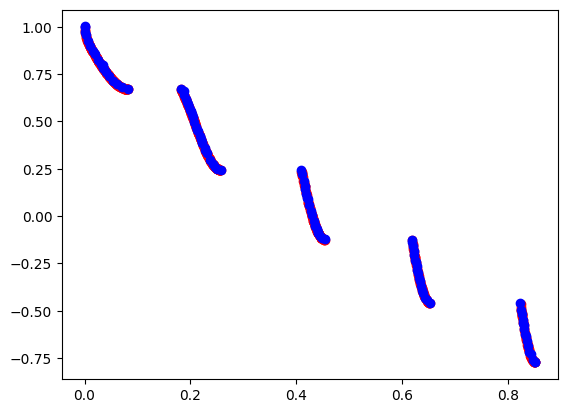

In [8]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox2 = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox2.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox2.register("individual", tools.initIterate, creator.Individual, toolbox2.attr_float)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)

toolbox2.register("evaluate", benchmarks.zdt3)
toolbox2.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox2.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox2.register("select", tools.selNSGA2)

check_results(toolbox2,'zdt3')

In [3]:
import numpy as np
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)

toolbox3 = base.Toolbox()

# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = -4.0, 4.0

def fon_objective(x):
    """
    Computes the two objective functions for the FON problem.

    Parameters:
        x (numpy array): A 1D numpy array with 3 elements.

    Returns:
        tuple: (f1, f2) values of the objective functions.
    """
    if len(x) != 3:
        raise ValueError("Input must be a numpy array of size 3.")

    f1 = 1 - np.exp(-np.sum((x - 1/np.sqrt(3))**2))
    f2 = 1 - np.exp(-np.sum((x + 1/np.sqrt(3))**2))

    return f1, f2

NDIM = 3

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

toolbox3.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox3.register("individual", tools.initIterate, creator.Individual, toolbox3.attr_float)
toolbox3.register("population", tools.initRepeat, list, toolbox3.individual)

toolbox3.register("evaluate", fon_objective)
toolbox3.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox3.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox3.register("select", tools.selNSGA2)

main(toolbox3)

/home/mm/projects/ewolucyjne/ewolucyjne/.venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mm/projects/ewolucyjne/ewolucyjne/.venv/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	evals	std	min                    	avg	max    
0  	100  	   	[0.60603453 0.23889407]	   	[1. 1.]
1  	100  	   	[0.60603453 0.23889407]	   	[1. 1.]
2  	100  	   	[0.28942203 0.21283759]	   	[0.99999369 0.99999214]
3  	100  	   	[0.25274034 0.18163321]	   	[0.99816136 0.99968148]
4  	100  	   	[0.17473249 0.11585175]	   	[0.99909329 0.99931595]
5  	100  	   	[0.17473249 0.11585175]	   	[0.99682948 0.99827587]
6  	100  	   	[0.04160718 0.0567531 ]	   	[0.9949125  0.99673003]
7  	100  	   	[0.04160718 0.0567531 ]	   	[0.9949125  0.98987105]
8  	100  	   	[0.04160718 0.01801418]	   	[0.99263419 0.99230517]
9  	100  	   	[0.04148298 0.01801418]	   	[0.99263419 0.98987105]
10 	100  	   	[0.04114614 0.01337986]	   	[0.98252208 0.98987105]
11 	100  	   	[0.01215875 0.01337986]	   	[0.98099995 0.98598459]
12 	100  	   	[0.01215875 0.0124786 ]	   	[0.97349685 0.98598459]
13 	100  	   	[0.01215875 0.00682223]	   	[0.97780129 0.98598459]
14 	100  	   	[0.01215875 0.00682223]	   	[0.97780129 0.98

([Individual('d', [0.5785133499993346, 0.5793543232515632, 0.577484831073043]),
  Individual('d', [0.5785133499993346, 0.5793543232515632, 0.577484831073043]),
  Individual('d', [-0.5786107092786217, -0.5796186044403003, -0.5747168098575017]),
  Individual('d', [-0.5786107092786217, -0.5796186044403003, -0.5747168098575017]),
  Individual('d', [-0.23461842095480123, -0.333703176896642, -0.25779324532164666]),
  Individual('d', [0.4742115339087525, 0.3606470765526111, 0.39519604212174175]),
  Individual('d', [0.04835376414122966, 0.009032797131802855, 0.022463112870288654]),
  Individual('d', [0.2554902130755124, 0.27213166524830923, 0.2928890578542148]),
  Individual('d', [-0.23655058366405718, -0.20637936321052064, -0.25779324532164666]),
  Individual('d', [-0.2915273076707284, -0.3018148268857276, -0.32590604464663897]),
  Individual('d', [0.15429979847496247, 0.14698582236227084, 0.28136644784015347]),
  Individual('d', [-0.04096796148289289, -0.03588212031345085, -0.087115485912838